In [1]:
import datastore

import pandas as pd
import matplotlib.pyplot as plt

spot = datastore.getSpotPrice()

total_consumption_production = datastore.getTotalConsumptionProduction()

production_se1_mwh = datastore.getAllSE1ProductionMWh() 
production_se2_mwh = datastore.getAllSE2ProductionMWh()
production_se3_mwh = datastore.getAllSE3ProductionMWh()
production_se4_mwh = datastore.getAllSE4ProductionMWh()

transTo = datastore.getTransmissionCapTo()
transFrom = datastore.getTransmissionCapFrom()

# netFlow = datastore.getNetFlow() # Too many missing values
flow = datastore.getFlow()

capTo = datastore.getFlowCapacityTo()
capFrom = datastore.getFlowCapacityFrom()

exchangeFrom = datastore.getExchangeFrom()
exchangeTo = datastore.getExchangeTo() 

turnOver = datastore.getTurnover()

temp_pen = datastore.getDailyWeather() # DAILY celsius
wind_velocities = datastore.getHourlyWindVelocity() # m/s
hydroReservoirs = datastore.getWeeklyHydroReservs() # GWh

Missing values in Index(['spotPrice'], dtype='object') : 6
Missing values in Index(['ConsumptionGWh', 'ProductionGWh'], dtype='object') : 14
Missing values in Index(['waterSE1(MWh)', 'windSE1(MWh)', 'trmSE1MWh'], dtype='object') : 46
Missing values in Index(['waterSE2(MWh)', 'windSE2(MWh)', 'solSE2MWh', 'trmSE2MWh', 'OthSE2MWh'], dtype='object') : 144
Missing values in Index(['waterSE3(MWh)', 'windSE3(MWh)', 'nucSE3(MWh)', 'solSE3MWh',
       'trmSE3MWh', 'OthSE3MWh'],
      dtype='object') : 139
Missing values in Index(['waterSE4(MWh)', 'windSE4(MWh)', 'solSE4MWh', 'trmSE4MWh', 'OthSE4MWh'], dtype='object') : 155
Missing values in Index(['TDK1SE3', 'TNO1SE3', 'TSE2SE3', 'TF1SE3', 'TSE4SE3'], dtype='object') : 0
Missing values in Index(['TSE3DK1', 'TSE3NO1', 'TSE3SE2', 'TSE3F1', 'TSE3SE4'], dtype='object') : 0
Missing values in Index(['F_LOWSE2SE3', 'F_LOWSE3FI', 'F_LOWSE3SE4'], dtype='object') : 6289
Missing values in Index(['C_SE4SE3', 'C_DK1SE3', 'C_FISE3', 'C_NO1SE3', 'C_SE2SE3'], 

In [2]:
import calendar_features as cf

dataset = pd.concat([spot, total_consumption_production,
                     production_se1_mwh, production_se2_mwh, production_se3_mwh, production_se4_mwh, 
                     transTo, transFrom, 
                     flow, capTo, capFrom, exchangeFrom, exchangeTo,
                     turnOver, wind_velocities, hydroReservoirs, temp_pen], axis=1)

dataset.interpolate(method = 'linear', limit_direction = 'forward', inplace=True, axis=0)

# daylight_features = cf.daylight_extractor(dataset)
holiday_features = cf.get_holidays(dataset)
dataset = cf.calendar_transformer(dataset)

dataset = pd.concat([dataset, holiday_features], axis=1)
dataset = pd.get_dummies(dataset, columns=["year", "month", "day_of_week", "hour"])


dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 54024 entries, 2018-01-01 00:00:00 to 2024-02-29 23:00:00
Columns: 113 entries, spotPrice to hour_23
dtypes: float64(61), int32(1), int64(1), uint8(50)
memory usage: 28.7 MB


In [3]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

target_scaler = MinMaxScaler()
neg_feature_scaler = MinMaxScaler()
pos_feature_scaler = MinMaxScaler()

negative_features = dataset.columns[dataset.lt(0).any()].drop("spotPrice")
positive_features = dataset.columns[dataset.gt(0).any()].drop(negative_features).drop("spotPrice")
target = dataset["spotPrice"].to_frame()

neg_features_scaled = neg_feature_scaler.fit_transform(dataset[negative_features])
pos_features_scaled = pos_feature_scaler.fit_transform(dataset[positive_features])

y = target_scaler.fit_transform(target)
x = np.concatenate([neg_features_scaled, pos_features_scaled], axis=1)

train_split = '2021-12-31 23:00:00'
val_split = '2022-12-31 23:00:00'
test_split = '2024-02-29 23:00:00'

train_split_index = dataset.index.get_loc(train_split)
val_split_index = dataset.index.get_loc(val_split)
test_split_index = dataset.index.get_loc(test_split)

x_train = x[:train_split_index]
y_train = y[:train_split_index]

x_val = x[train_split_index:val_split_index]
y_val = y[train_split_index:val_split_index]

x_test = x[val_split_index:test_split_index]
y_test = y[val_split_index:test_split_index]

In [ ]:
# convert history into inputs and outputs

data = np.concatenate([x, y], axis=1)
n_input = 24 * 5 * 2

def split_dataset(data):
 # split into standard weeks
 train, val = data[:train_split_index], data[train_split_index:val_split_index]
 # restructure into windows of weekly data
 train = np.array(np.split(train, len(train)/7))
 val = np.array(np.split(val, len(val)/7))
 return train, val

train, val = split_dataset(data)

def to_supervised(train, n_input, n_out=7):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end <= len(data):
			X.append(data[in_start:in_end, :])
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return np.array(X), np.array(y)

# make a forecast
def forecast(model, history, n_input):
	# flatten data
	data = np.array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:, :]
	# reshape into [1, n_input, n]
	input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)
	# we only want the vector forecast
	yhat = yhat[0]
	return yhat


train_x, train_y = to_supervised(train, n_input)

In [8]:
import keras

past = 24 * 5 * 2
future = 24 * 5

seq_length = int(past)
batch_size = 64

train_gen = keras.utils.timeseries_dataset_from_array(
    x_train, y_train, 
    sequence_length = seq_length, sequence_stride=1, sampling_rate=1, batch_size=batch_size
)
val_gen = keras.utils.timeseries_dataset_from_array(
    x_val, y_val, 
    sequence_length = seq_length, sequence_stride=1, sampling_rate=1, batch_size=batch_size
)
test_gen = keras.utils.timeseries_dataset_from_array(
    x_test, y_test, 
    sequence_length = seq_length, sequence_stride= 1, sampling_rate=1, batch_size = 1
)

for batch in train_gen.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (64, 240, 112)
Target shape: (64, 1)


In [ ]:
import keras
from keras.layers import LSTM, Dense, Input, Dropout, Bidirectional, RepeatVector, TimeDistributed
keras.utils.clear_session()

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

model = keras.Sequential([
    Input(shape=(inputs.shape[1], inputs.shape[2])),
    LSTM(16, return_sequences=False, activation="relu"),
    Dropout(0.5),
    
    RepeatVector(future),
    
    LSTM(16, return_sequences=True, activation="relu"),
    TimeDistributed(Dense(16, activation="relu")),
    TimeDistributed(Dense(1))
])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mae", metrics=["mse"])
model.summary()

In [ ]:
epochs = 36

history = model.fit(
    train_gen,
    validation_data= val_gen,
    epochs = epochs,
    callbacks = [early_stopping],
    shuffle = False
)

def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

visualize_loss(history, "Training and Validation Loss")

In [12]:
test_gen = keras.utils.timeseries_dataset_from_array(
    x_test, y_test, 
    sequence_length = seq_length, sequence_stride = future, sampling_rate=1, batch_size = 1
)

preds = model.predict(test_gen)
# preds = np.squeeze(preds)
# preds = preds[:, 1]

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


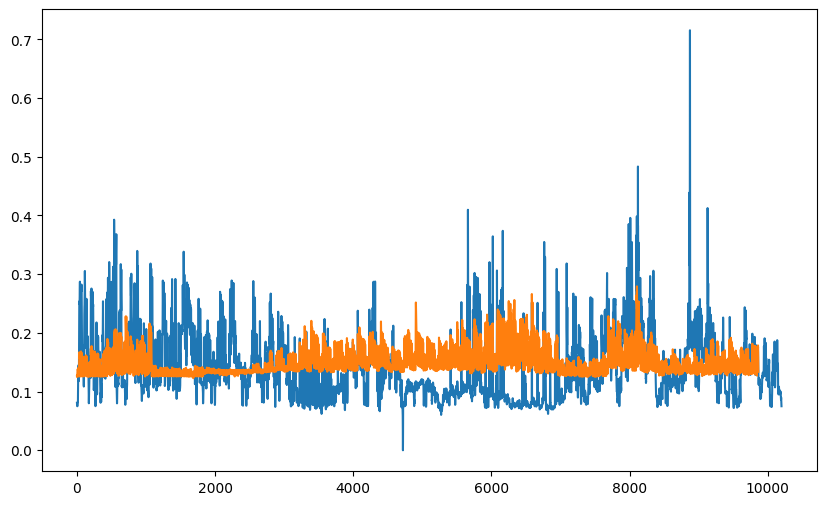

In [126]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label="True")
plt.plot(preds, label="Predicted")

In [ ]:
mae = np.mean(np.abs(y_pred_ - actuals))
rmse = np.sqrt(np.mean(np.square(y_pred_ - actuals))) 
smape = np.mean(np.abs(y_pred_ - actuals) / (np.abs(y_pred_) + np.abs(actuals))) 
print("Mean Absolute Error:", mae)
print("Root Mean Squared Error:", rmse)
print("Symmetric Mean Absolute Percentage Error:", smape)

plt.plot(y_pred_, label="Predicted")
plt.plot(y_test, label="True")

In [53]:
import tensorflow as tf


# y_pred = model.predict(test_gen)
ds = test_gen.unbatch()
ds_features = np.asarray(list(ds.map(lambda x, y: x)))
y_true = np.asarray(list(ds.map(lambda x, y: y)))

# y_pred = model.predict(ds_features)
# input_x = ds_features[:, :past]

def forecast(model, history, n_input):
 # flatten data
 data = np.array(history)
 data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
 # retrieve last observations for input data
 input_x = data[-n_input:, :]
 # reshape into [1, n_input, n]
 input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))

 yhat = model.predict(input_x, verbose=0)
 # we only want the vector forecast
 yhat = yhat[0]
 return yhat


In [ ]:
train = np.concatenate([y_train, x_train], axis=1)
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=7):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end <= len(data):
			X.append(data[in_start:in_end, :])
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return np.array(X), np.array(y)

# train_x , train_y = to_supervised(train, past+future, future)

In [ ]:
# y_hat_ = forecast(model, ds_features, seq_length)

predictions = []

for i in range(0, past - future, future):
    y_hat_ = model.predict()
    predictions.append(y_hat_)

In [ ]:
import numpy as np

y_pred = model.predict(x_test)

y_pred = target_scaler.inverse_transform(y_pred)
actuals = target_scaler.inverse_transform(y_test)

mae = np.mean(np.abs(y_pred - actuals))
rmse = np.sqrt(np.mean(np.square(y_pred - actuals))) 
smape = np.mean(np.abs(y_pred - actuals) / (np.abs(y_pred) + np.abs(actuals))) 
print("Mean Absolute Error:", mae)
print("Root Mean Squared Error:", rmse)
print("Symmetric Mean Absolute Percentage Error:", smape)

plt.figure(figsize=(17, 6))
plt.plot(y_pred, label='Predictions', linestyle='--')
plt.plot(actuals, label='Actuals', alpha=0.7)
plt.legend()
plt.show()

In [9]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

target_scaler = MinMaxScaler()
neg_feature_scaler = MinMaxScaler()
pos_feature_scaler = MinMaxScaler()

negative_features = dataset.columns[dataset.lt(0).any()].drop("spotPrice")
positive_features = dataset.columns[dataset.gt(0).any()].drop(negative_features).drop("spotPrice")
target = dataset["spotPrice"].to_frame()

neg_features_scaled = neg_feature_scaler.fit_transform(dataset[negative_features])
pos_features_scaled = pos_feature_scaler.fit_transform(dataset[positive_features])

y = target_scaler.fit_transform(target)
x = np.concatenate([neg_features_scaled, pos_features_scaled], axis=1)

X = []
Y = []
H = 1

past = 24 * 5 * 2

for i in range(past, len(y) - H + 1):
    X.append(x[i - past: i])
    Y.append(y[i: i + H])

X = np.array(X)
Y = np.array(Y)


train_split = '2021-12-31 23:00:00'
val_split = '2022-12-31 23:00:00'
test_split = '2024-02-29 23:00:00'

train_split_index = dataset.index.get_loc(train_split)
val_split_index = dataset.index.get_loc(val_split)
test_split_index = dataset.index.get_loc(test_split)

x_train = X[:train_split_index]
y_train = Y[:train_split_index]

x_val = X[train_split_index:val_split_index]
y_val = Y[train_split_index:val_split_index]

x_test = X[val_split_index:test_split_index]
y_test = Y[val_split_index:test_split_index]




In [12]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

target_scaler = MinMaxScaler()
neg_feature_scaler = MinMaxScaler()
pos_feature_scaler = MinMaxScaler()

negative_features = dataset.columns[dataset.lt(0).any()].drop("spotPrice")
positive_features = dataset.columns[dataset.gt(0).any()].drop(negative_features).drop("spotPrice")
target = dataset["spotPrice"].to_frame()

neg_features_scaled = neg_feature_scaler.fit_transform(dataset[negative_features])
pos_features_scaled = pos_feature_scaler.fit_transform(dataset[positive_features])

y = target_scaler.fit_transform(target)
x = np.concatenate([neg_features_scaled, pos_features_scaled], axis=1)

train_split = '2021-12-31 23:00:00'
val_split = '2022-12-31 23:00:00'
test_split = '2024-02-29 23:00:00'

train_split_index = dataset.index.get_loc(train_split)
val_split_index = dataset.index.get_loc(val_split)
test_split_index = dataset.index.get_loc(test_split)

x_train = x[:train_split_index]
y_train = y[:train_split_index]

x_val = x[train_split_index:val_split_index]
y_val = y[train_split_index:val_split_index]

x_test = x[val_split_index:test_split_index]
y_test = y[val_split_index:test_split_index]


def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []

    for i in range(len(X) - time_steps):
        #subsequence starting at 1 to i+time_steps - dim: time_steps x features
        v = X[i:(i + time_steps)]
        #append the sub sequence to the list - dim: (len-time_steps)x time_steps x features
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

x_train, y_train = create_dataset(x_train, y_train, time_steps=24)
x_val, y_val = create_dataset(x_val, y_val, time_steps=24)
x_test, y_test = create_dataset(x_test, y_test, time_steps=24)

In [14]:
import keras
from keras.layers import LSTM, Dense, Input, Dropout, Bidirectional, RepeatVector, TimeDistributed
keras.utils.clear_session()

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

model = keras.Sequential([
    Input(shape=(x_train.shape[1], x_train.shape[2])),
    (LSTM(32)),
    Dropout(0.2),
    (Dense(1))
])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mae", metrics=["mse"])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 32)             │        18,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,593 (72.63 KB)

 Trainable params: 18,593 (72.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0632 - mse: 0.0128 - val_loss: 0.0888 - val_mse: 0.0184
Epoch 2/50
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0094 - mse: 2.8213e-04 - val_loss: 0.0877 - val_mse: 0.0149
Epoch 3/50
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0093 - mse: 3.3904e-04 - val_loss: 0.0814 - val_mse: 0.0148
Epoch 4/50
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0080 - mse: 2.1997e-04 - val_loss: 0.0818 - val_mse: 0.0157
Epoch 5/50
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0072 - mse: 1.7763e-04 - val_loss: 0.0781 - val_mse: 0.0140
Epoch 6/50
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0072 - mse: 1.9236e-04 - val_loss: 0.0764 - val_mse: 0.0135
Epoch 7/50
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0069 - mse: 1.7214e-04 - val_loss: 0.0816 - val_mse: 0.0153
Epoch 8/50
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0070 - mse: 1.6248e-04 - val_loss: 0.0783 - val_mse: 0.0143
Epoch 9/50
1

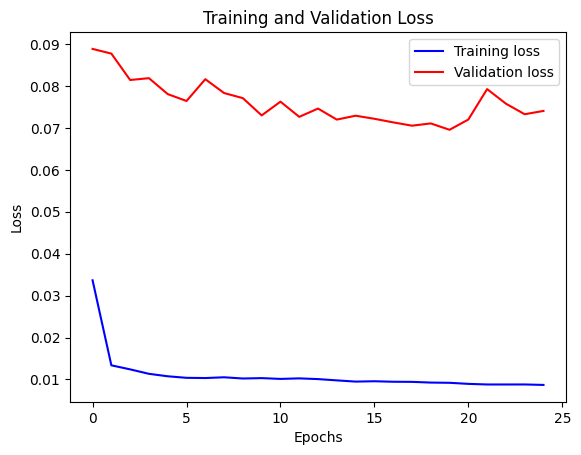

In [15]:
epochs = 50

history = model.fit(
    x_train, y_train,
    validation_data= (x_val, y_val),
    epochs = epochs,
    callbacks = [early_stopping],
    shuffle = False
)

def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

visualize_loss(history, "Training and Validation Loss")

In [31]:
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

def create_dataset(df, n_deterministic_features,
                   window_size, forecast_size,
                   batch_size):
    # Feel free to play with shuffle buffer size
    shuffle_buffer_size = len(df)
    # Total size of window is given by the number of steps to be considered
    # before prediction time + steps that we want to forecast
    total_size = window_size + forecast_size

    df = df.astype('float32')
    data = tf.data.Dataset.from_tensor_slices(df.values)
    
    #

    # Selecting windows
    data = data.window(total_size, shift=1, drop_remainder=True)
    data = data.flat_map(lambda k: k.batch(total_size))

    # Shuffling data
    data = data.shuffle(shuffle_buffer_size, seed=42)

    # Extracting past features + deterministic future + labels
    data = data.map(lambda k: ((k[:-forecast_size],
                                k[-forecast_size:, -n_deterministic_features:]),
                               k[-forecast_size:, 0]))
    #tf.data.experimental.AUTOTUNE
    return data.batch(batch_size).prefetch(tf.data.AUTOTUNE)

window_len = 24 * 5
forecast_len = 24 * 5
futr_exog_list = len(dataset.iloc[:, 59:].columns.to_list())
hist_exog_list = len(dataset.iloc[:, 1:59].columns.to_list())

total_features = dataset.shape[1]

scaler = MinMaxScaler()
dataset[dataset.columns] = scaler.fit_transform(dataset[dataset.columns])

train_split = '2021-12-31 23:00:00'
val_split = '2022-12-31 23:00:00'
test_split = '2024-02-29 23:00:00'


train_df = dataset.loc[:train_split]
val_df = dataset.loc[train_split:val_split]
test_df = dataset.loc[val_split:test_split]

batch_size = 64

training_windowed = create_dataset(train_df,
                                   futr_exog_list,
                                   window_len,
                                   forecast_len,
                                   batch_size)

validation_windowed = create_dataset(val_df,
                                     futr_exog_list,
                                     window_len,
                                     forecast_len,
                                     batch_size)

test_windowed = create_dataset(test_df,
                               futr_exog_list,
                               window_len,
                               forecast_len,
                               batch_size=1)

In [35]:
from keras import ops
import keras

keras.backend.clear_session()
 
def rmse(y_true, y_pred):
	return ops.sqrt(ops.mean(ops.square(y_pred - y_true), axis=-1))

def get_dropout(input_tensor, p=0.5):
    return keras.layers.Dropout(p)(input_tensor, training=True)

latent_dim = 32

# First branch of the net is an lstm which finds an embedding for the past
past_inputs = keras.Input(shape=(window_len, 
                                 total_features), name='past_inputs')

# Encoding the past
encoder = keras.layers.LSTM(latent_dim, return_state=True)

encoder_outputs, state_h, state_c = encoder(past_inputs) 

future_inputs = keras.Input(shape=(forecast_len, futr_exog_list), 
                            name='future_inputs')

# Combining future inputs with recurrent branch output
decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences=True)

x = decoder_lstm(future_inputs,
                 initial_state=[state_h, state_c])
x = get_dropout(x, p=0.25)

x = keras.layers.Dense(16, activation='leaky_relu')(x)
x = get_dropout(x, p=0.25)
x = keras.layers.Dense(16, activation='leaky_relu')(x)
x = get_dropout(x, p=0.25)
output = keras.layers.Dense(1, activation='linear')(x)

model = keras.models.Model(inputs=[past_inputs, future_inputs], 
                           outputs=output)

optimizer = keras.optimizers.Adam()
loss = keras.losses.MeanAbsoluteError()

model.compile(loss=loss, 
              optimizer=optimizer,
              metrics=[keras.metrics.MeanSquaredError()])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ past_inputs         │ (None, 120, 113)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ future_inputs       │ (None, 120, 54)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 32),      │     18,688 │ past_inputs[0][0] │
│                     │ (None, 32),       │            │                   │
│                     │ (None, 32)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 120, 32)   │     11,136 │ future_inputs[0]… │
│                     │                   │            │ lstm[0][1],       │
│                     │                   │            │ lstm[0][2]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 120, 32)   │          0 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 120, 16)   │        528 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 120, 16)   │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 120, 16)   │        272 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 120, 16)   │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 120, 1)    │         17 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 30,641 (119.69 KB)

 Trainable params: 30,641 (119.69 KB)

 Non-trainable params: 0 (0.00 B)

In [36]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(training_windowed, 
                    epochs=35,
                    validation_data=validation_windowed, 
                    callbacks=[early_stopping]
                    )


Epoch 1/35
    545/Unknown 157s 274ms/step - loss: 0.0404 - mean_squared_error: 0.0055

c:\Users\drami\AppData\Local\Programs\Python\Python310\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


KeyboardInterrupt: 

In [8]:
model.evaluate(test_windowed)

9842/9842 ━━━━━━━━━━━━━━━━━━━━ 59s 6ms/step - loss: 0.0443 - mean_squared_error: 0.0034


c:\Users\drami\AppData\Local\Programs\Python\Python310\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


[0.04418519139289856, 0.0033685502130538225]

In [43]:
preds = model.predict(test_windowed)
preds = np.squeeze(preds)

9842/9842 ━━━━━━━━━━━━━━━━━━━━ 55s 5ms/step


In [44]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

preds_mean = preds[:, 0]
y_true = test_df['spotPrice'].values
y_true_ = y_true[:len(preds_mean)]

mae = mean_absolute_error(y_true_, preds_mean)

In [ ]:
plt.figure(figsize=(20, 8))
plt.plot(preds[:,0], label="Predictions" , linestyle='--') 
# plt.plot(test_df['spotPrice'].values, label="True")

In [10]:
for i, data in enumerate(test_windowed.take(1)):
  (past, future), truth = data

In [ ]:
samples = 1000
preds = []

for i in range(samples):
    preds.append(model.predict((past, future)))

In [27]:
a = np.concatenate(preds, axis=0).squeeze()

In [ ]:
ci_upper = np.mean(a, axis=0) + 1.96 * (np.std(a, axis=0) / np.sqrt(samples))
ci_lower = np.mean(a, axis=0) - 1.96 * (np.std(a, axis=0) / np.sqrt(samples))

plt.figure(figsize=(20, 8))
plt.plot(ci_upper, label="Upper CI", linestyle='--')
plt.plot(ci_lower, label="Lower CI", linestyle='--')
plt.plot(np.mean(a, axis=0), label="Mean Prediction")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


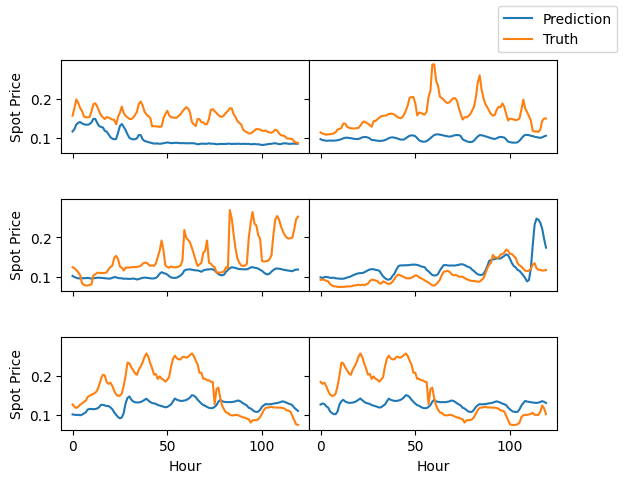

In [30]:
fig, ax = plt.subplots(nrows=3, ncols=2, sharex='all', sharey='all')

for i, data in enumerate(test_windowed.take(6)):
  (past, future), truth = data

  pred = model.predict((past,future)) 

  row = i//2
  col = i%2

  ax[row][col].plot(pred.flatten(), label='Prediction')
  ax[row][col].plot(truth.numpy().flatten(),label='Truth')

# Labeling axes
for i in range(2):
  ax[2][i].set_xlabel('Hour')
for i in range(3):
  ax[i][0].set_ylabel('Spot Price')

handles, labels = ax[0][0].get_legend_handles_labels()
fig.subplots_adjust(wspace=0, hspace=0.5)
fig.legend(handles, labels, loc='upper right')